# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## Asignación de vuelos a gates en aeropuerto

Esta  notebook implementa un algoritmo genético monoobjetivo para la resolución de la asignación de vuelos a gates. Los operadores de cruzamiento y mutación NO aseguran que los individuos representen vuelos diferentes y gates diferentes.

#### Representacion de Individuo:

Un objeto Individual representaa una determinada asignacion de un subconjunto de vuelos (almacenado en <b>list_of_flights</b>) a un conjunto de gates (almacenado en <b>chromosome</b>). La lista de gates disponibles que se pueden asignar a los vuelos se almacena en la variable <b>allele_pool</b>  del individuo. Ver el siguiente grafico ilustrativo:

<img src="EjemploIndividuoAvion.jpg">



In [2]:
import sys
import time
import numpy as np
import random
from random import seed, randint, sample, uniform, randrange
from copy import deepcopy
import matplotlib.pyplot as plt

### Clase <b>Individual</b>

Esta es una clase para definir a un individuo de la población. Cada individuo posee un cromosoma, los vuelos a asignar, todos los posibles alelos y su respectivo fitness. Además, los métodos de esta clase permiten realizar el cruzamiento (crossover) y la mutación (mutation) sobre el cromosoma del individuo.

In [438]:
# Clase que implementa el individuo y sus operadores
class Individual(object):
    
    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):  
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1 # -1 indica que el individuo no ha sido evaluado
        #self.fitness = [-1.-1]


    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.gates))  # escoge aleatoriamento una posicion en la lista gates
        ind1 = Individual(self.flights, self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []
        gates_ind2 = []
        
        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
                gates_ind1.append(self.gates[i])
                gates_ind2.append(other.gates[i])
            else:
                gates_ind1.append(other.gates[i])
                gates_ind2.append(self.gates[i])
        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]
    
    def crossover_orderpermutation(self, other):
        pos_constantes_flights = []
        pos_constantes_flights = random.sample(range(len(self.flights)),len(self.flights)//2)
        new_flights1 = [-1]*len(self.flights)
        new_flights2 = [-1]*len(other.flights)

        for index in pos_constantes_flights:
            new_flights1[index] = self.flights[index]
            new_flights2[index] = other.flights[index]

        for i in range(len(self.flights)):
            if(new_flights1[i] == -1):
                for j in range(len(self.flights)):
                    list_identifiers_new_flights1 = []
                    for k in range(len(new_flights1)):
                        #if not isinstance(new_flights1.identifier, list): 
                        #    list_identifiers_new_flights1 = list_identifiers_new_flights1 + [new_flights1.identifier]
                        list_identifiers_new_flights1 = list_identifiers_new_flights1 + [getattr(new_flights1[k], 'identifier', -1)]
                    
                    if other.flights[j].identifier not in list_identifiers_new_flights1:
                        new_flights1[i] = other.flights[j]
                        #break
                # En caso de que no encuentre ningún vuelo que asignar
                if new_flights1[i] == -1:
                    self.flights_pool[randrange(0, len(self.flights_pool))]
                
                for j in range(len(other.flights)):
                    list_identifiers_new_flights2 = []
                    for k in range(len(new_flights2)):
                        #if not isinstance(new_flights2.identifier, list): 
                        #    list_identifiers_new_flights2 = list_identifiers_new_flights2 + [new_flights2.identifier]
                        list_identifiers_new_flights2 = list_identifiers_new_flights2 + [getattr(new_flights2[k], 'identifier', -1)]
                    
                    if self.flights[j].identifier not in list_identifiers_new_flights2:
                        new_flights2[i] = self.flights[j]
                        #break
                # En caso de que no encuentre ningún vuelo que asignar
                if new_flights2[i] == -1:
                    other.flights_pool[randrange(0, len(other.flights_pool))]
                    
        ind1 = Individual(new_flights1, self.gates, self.flights_pool, self.gates_pool)
        ind2 = Individual(new_flights2, other.gates, self.flights_pool, self.gates_pool)
        return [ind1, ind2]
  
    def mutate_position(self):
        "Cambia aleatoriamente el Gate asignado a un Flight."
        mutated_flights = deepcopy(self.flights)
        indexFlight = randrange(0, len(self.flights)) # escoje el indice del elemento de gates que sera mutado
        newFlight = self.flights_pool[randrange(0, len(self.flights_pool))]
        mutated_flights[indexFlight] = newFlight
        return Individual(mutated_flights, self.gates, self.flights_pool, self.gates_pool)
    
    def mutate_swap(self):
        "Escoge dos genes e intercambia sus alelos"
        mutated_gates = deepcopy(self.gates[:])
        mutGen1 = random.randrange(1,len(mutated_gates))
        mutGen2 = random.randrange(1,len(mutated_gates))
        temp = mutated_gates[mutGen1]
        mutated_gates[mutGen1] = mutated_gates[mutGen2]
        mutated_gates[mutGen2] = temp

        mutated_flights = deepcopy(self.flights[:])
        mutGen1 = random.randrange(1,len(mutated_flights))
        mutGen2 = random.randrange(1,len(mutated_flights))
        temp = mutated_flights[mutGen1]
        mutated_flights[mutGen1] = mutated_flights[mutGen2]
        mutated_flights[mutGen2] = temp
        return Individual(mutated_flights, mutated_gates, self.flights_pool, self.gates_pool)
    

In [373]:
best_ind.flights_pool[randrange(0, len(best_ind.flights_pool))]

### Clase <b>Gate</b>

Esta es una clase abstracta para definir los lugares donde los vuelos serán asignados. Se debe hacer subclases con el fin de diferenciar los tipos de lugar donde un vuelo puede ser asignado.

In [4]:
class Gate(object):
    def __init__(self, identifier, x, y, z):
        self.identifier = identifier   # identificador del Gate
        self.distance = x              # en el caso de Sleeve esto almacena la longitud de manga. En el caso de zonas es la distancia a una puerta del aeropuerto 
        self.potential_of_speed = y    # en el caso de Sleeve esto almacena la velocidad de pasajeros en manga. En el caso de zona almacena la velocidad del bus 
        self.number_of_persons_every_10m = z   # en el caso de Sleeve esto almacena el numero de personas cada 10 metros. En el cazo de zona es la capacidad del bus
  
    def __hash__(self):
        return self.identifier

### Clase <b>Sleeve</b>

Esta clase implementa concretamente el Gate tipo Sleeve (Manga). En este tipo de gate, los pasajeros deben realizar un recorrido a pie hasta abandonar totalmente el Gate. Se tiene en cuenta la longitud de la manga, la velocidad de los pasajeros y la cantidad de personas que pueden estar cada 10m (este valor es variable porque ya refleja el ancho de la manga, puesto que una manga más ancha permite una mayor cantidad de pasajeros).

In [5]:
class Sleeve(Gate):
    def __init__(self, identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m):
        super().__init__(identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m)

### Clase <b>Zone</b>

Esta clase implementa concretamente el Gate tipo Zone (zona). En este tipo de gate, los pasajeros son recogidos por un bus y son llevados hasta una puerta. Se tiene en cuenta la distancia de la zona a la puerta, la velocidad y capacidad del bus.

In [6]:
class Zone(Gate):
    def __init__(self, identifier, distance_zone_door, speed_bus, capacity_of_bus):
        super().__init__(identifier, distance_zone_door, speed_bus, capacity_of_bus)

### Clase <b>Flight</b>

Esta es una clase para definir a los vuelos a asignar. Cada vuelo posee una capacidad máxima, la cantidad de pasajeros, el tiempo de estacionamiento que le toma al vuelo, la longitud de las alas del avión, el tiempo de inspección al avión luego de aterrizar, el tiempo que demorarían en bajar las escaleras los pasajeros si el avión estuviera repleto, el momento de llegada al aeropuerto y el momento en que debería irse del aeropuerto.

In [7]:
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs  
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto
  
    def __hash__(self):
        return self.identifier

### Funciones utilitarias para generar los Gates y Vuelos</b>
Estas son funciones utilitarias para generar automáticamente los Gates y Vuelos

In [8]:
# Genera una lista de Gates
def generate_list_of_gates(number_of_gates, max_length_of_sleeve=20, max_speed_of_passengers_on_sleeve=3, max_number_of_passengers_every_10m=12, max_distance_zone_door=50, max_speed_bus=15, max_capacity_of_bus=200):
  list_of_gates = list()

  for gate_identifier in range(number_of_gates):
    gate_type = randint(0, 1)

    if gate_type == 0:   # caso manga
      distance = randint(1, max_length_of_sleeve)
      potential_of_speed = randint(1, max_speed_of_passengers_on_sleeve)
      number_of_persons_every_10m = randint(1, max_number_of_passengers_every_10m)

      gate = Sleeve(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
   
    else:    # caso zone
      distance = randint(1, max_distance_zone_door)
      potential_of_speed = randint(1, max_speed_bus)
      number_of_persons_every_10m = randint(1, max_capacity_of_bus)

      gate = Zone(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
    
    list_of_gates.append(gate)
  
  return list_of_gates

# Genera una lista de Flights
def generate_list_of_flights(number_of_flights, max_maximum_capacity=100, max_number_of_passengers_factor=0.8, max_parking_time=30, max_length_wings=25, max_inspection_time=180, max_landing_time_on_stairs=60, max_arriving_time=200, max_leaving_time=1000):
  list_of_flights = list()

  max_number_of_passengers = int(np.floor(max_number_of_passengers_factor * max_maximum_capacity))

  for flight_identifier in range(number_of_flights):
    maximum_capacity = randint(max_number_of_passengers, max_maximum_capacity)
    number_of_passengers = randint(1, max_number_of_passengers)
    parking_time = randint(1, max_parking_time)
    length_wings = randint(1, max_length_wings)
    inspection_time = randint(1, max_inspection_time)
    landing_time_on_stairs = randint(1, max_landing_time_on_stairs)
    arriving_time = randint(1, max_arriving_time)
    leaving_time = randint(max_arriving_time + 1, max_leaving_time)

    flight = Flight(flight_identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time)
    
    list_of_flights.append(flight)
  
  return list_of_flights

### Funciones utilitarias para ordenar los Vuelos y Gates</b>
Estas son funciones utilitarias para ordenar los Vuelos acorde a su deseabilidad y los Gates por su flujo personas

In [9]:
# Funcion para ordenar vuelos por su grado de deseabilidad  ( nro_pasajeros/tiempo_en_aeropuerto )
def process_desirability(n):
  return n.number_of_passengers / (n.leaving_time - n.arriving_time)

# Funcion para ordenar Gates por su capacidad de flujo de personas  
def process_flow(n):
  return n.number_of_persons_every_10m * n.potential_of_speed * 10 / n.distance

### Funciones utilitarias para el Algoritmo Genético</b>
Estas son funciones utilitarias para realizar el Algoritmo Genético que se encargue de la asignación de vuelos

In [10]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo
    
    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [460]:
# Evalua una individuo representado por sus listas:  flights, gates
def fitness(flights, gates):
  grace_time = 5/100
  cumulative_passengers = 0
  cumulative_disembarkation_time = 0
  cumulative_efficiency = 0
  
  for flight, gate in zip(flights, gates):
    number_of_passengers = flight.number_of_passengers
    if isinstance(gate, Sleeve):  # si el gate es de tipo Manga 
      disembarkation_time_of_passengers = ( (number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) 
                                           + flight.parking_time + flight.inspection_time ) * (1 + grace_time)
    else:  # si el gate es de tipo Zona
      disembarkation_time_of_passengers = ( (number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time 
                                           + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) 
                                           + flight.inspection_time ) * (1 + grace_time)
    
    # la eficiencia de una asignacion flight-gate es la cantidad total de pasajeros desembarcados por unidad de tiempo 
    cumulative_passengers += number_of_passengers
    cumulative_disembarkation_time += disembarkation_time_of_passengers
    #cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers
  
  cumulative_efficiency = cumulative_passengers / cumulative_disembarkation_time
  
  # validar que un gate o vuelo no se repita en la solución
  list_identifiers_gates = []
  for i in range(len(gates)):
      list_identifiers_gates = list_identifiers_gates + [gates[i].identifier]
  list_identifiers_flights = []
  for i in range(len(flights)):
      list_identifiers_flights = list_identifiers_flights + [flights[i].identifier]

  if (len(list_identifiers_gates) != len(set(list_identifiers_gates))) | (len(list_identifiers_flights) != len(set(list_identifiers_flights))):
      cumulative_efficiency = 1
  
  return cumulative_efficiency


In [12]:
# Evaluar la población con la función fitness
def evaluate_population(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_fn(population[i].flights, population[i].gates)

In [13]:
# Selección de padres por el método roulette
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [14]:
# Selección de padres por el método de torneo
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

In [15]:
# Selección de la nueva población con metodo de ranking
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    survivors = sorted(population, key=lambda x: x.fitness, reverse=True)[:numsurvivors]
    next_population.extend(survivors)
    return next_population

### Algoritmo Genético

In [439]:
population = init_population(50, 10, list_of_flights, list_of_gates)
population_size = 50

In [444]:
evaluate_population(population, fitness)

for g in range(10): # ciclo evolutivo
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3

    ## Crea la poblacion descendencia cruzando las parejas del mating pool     
    offspring_population = []
    for i in range(len(mating_pool)):
        offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        offspring_population[i] = offspring_population[i].mutate_swap()

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness)
    population = select_survivors_ranking(population, offspring_population, 50)


In [461]:
#for i in range(len(offspring_population)):
    #print(offspring_population[i].flights)

In [462]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, 
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
  #seed(0)

  #Inicializa una poblacion inicial de forma aleatoria
  population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

  population_size = len(population)
  evaluate_population(population, fitness_fn)

  best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
  bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo  
  print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))
  
  for g in range(n_generations): # ciclo evolutivo
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(population_size/2)):
      if selection_fn == "roulette":
        mating_pool.append(select_parents_roulette(population))
      elif selection_fn == "tournament":
        mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
      else:
        raise NotImplementedError

    ## Crea la poblacion descendencia cruzando las parejas del mating pool     
    offspring_population = []
    for i in range(len(mating_pool)):
      if crossover == "onepoint":
        offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
      elif crossover == "uniform":
        offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )
      elif crossover == "orderpermutation":
        offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
      else:
        raise NotImplementedError
    
    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
      if uniform(0, 1) < p_mut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_swap()
        elif mutation == "swap":
          offspring_population[i] = offspring_population[i].mutate_swap()
        else:
          raise NotImplementedError  

    ## Evalua la poblacion descendencia creada
    evaluate_population(offspring_population, fitness_fn)
    
    ## Selecciona individuos para la sgte. generación con el metodo de ranking
    population = select_survivors_ranking(population, offspring_population, population_size) #metodo de ranking

    ## Almacena la historia del fitness del mejor individuo
    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
    bestfitness.append(best_ind.fitness)
        
    if (g % 10 == 0):  # muestra resultados cada 10 generaciones
      print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))
        
  return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen    

### Funciones utilitarias para manejar la solución del Algoritmo Genético</b>
Esta es una función utilitarias que permite mostrar la configuración usada en el Algoritmo Genético y la asignación de Vuelos a Gates encontrada en un individuo pasado (ind)

In [17]:
def make_solution_report(ind, selection_fn, crossover, mutation):
  print("Selection: {} - Crossover: {} - Mutation: {} - Fitness: {}".format(selection_fn, crossover, mutation, ind.fitness), flush=True)
  print("\n".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(ind.flights, ind.gates)]) + "\n", flush=True)

In [18]:
import pandas as pd
import datetime as dt

In [379]:
# Crear DataFrame
columnas = ['tipo_seleccion_padres', 'tipo_cruzamiento', 'tipo_mutacion', 'p_mut', 'tipo_seleccion_sobrevivientes'
            , 'avg_max_fitness', 'avg_convergence', 'date_time']
df = pd.DataFrame(columns=columnas)

def guardar_log_interacion(df, tipo_seleccion_padres, tipo_cruzamiento, tipo_mutacion, p_mut, tipo_seleccion_sobrevivientes, bestfitness):
    # Definiendo variables a guardar
    df_aux = pd.DataFrame(bestfitness, columns=['max_fitness']).reset_index()

    fecha_hora_registro = dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    max_fitness_sample = df_aux['max_fitness'].max()
    iteracion_convergencia = df_aux[df_aux['max_fitness'] == df_aux['max_fitness'].max()]['index'].min()

    # Datos de la nueva fila como un diccionario
    nueva_fila = {'tipo_seleccion_padres': tipo_seleccion_padres, 'tipo_cruzamiento': tipo_cruzamiento
                  , 'tipo_mutacion': tipo_mutacion, 'p_mut': p_mut
                  , 'tipo_seleccion_sobrevivientes': tipo_seleccion_sobrevivientes
                  , 'avg_max_fitness': max_fitness_sample, 'avg_convergence': iteracion_convergencia
                  , 'date_time': fecha_hora_registro}

    # Añadir la nueva fila al DataFrame
    df = pd.concat([df, pd.DataFrame([nueva_fila])], ignore_index=True)
    
    return df

## <b>Probando el Algoritmo Genético</b> 

### <b>Generación de Gates y Vuelos</b> 

Genera los Gates y Vuelos para que el Algoritmo Genético  realize la asignacion. Asegura que el numero de vuelos a asignar (**flights_to_assign**) no sea mayor a la cantidad de puertas 

In [463]:
seed(0)

number_of_gates = 10
number_of_flights = 30

# general los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# obtiene el numero de vuelos que el algoritmo genetico puede asignar (no puede ser mayor al numero de gates disponibles) 
flights_to_assign = number_of_flights if number_of_flights <= number_of_gates	else number_of_gates
  
# ordena los vuelos por su deseabilidad y los gates por su capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)

### <b>Experimentación con el Algoritmo Genético</b> 

Poblacion inicial, best_fitness = 0.3374498236602937
generacion 0, (Mejor fitness = 0.3374498236602937)
generacion 10, (Mejor fitness = 0.41226976983223135)
generacion 20, (Mejor fitness = 0.43936336479980775)
generacion 30, (Mejor fitness = 0.4440148344845449)
generacion 40, (Mejor fitness = 0.44424132242914816)
Poblacion inicial, best_fitness = 0.29079555636698956
generacion 0, (Mejor fitness = 0.29079555636698956)
generacion 10, (Mejor fitness = 0.38924896480936416)
generacion 20, (Mejor fitness = 0.44091728653000745)
generacion 30, (Mejor fitness = 0.4421016766807663)
generacion 40, (Mejor fitness = 0.4533900921598295)
Poblacion inicial, best_fitness = 0.2694701695330106
generacion 0, (Mejor fitness = 0.3218527910113165)
generacion 10, (Mejor fitness = 0.42275822986333506)
generacion 20, (Mejor fitness = 0.43194507684101086)
generacion 30, (Mejor fitness = 0.4394971073334006)
generacion 40, (Mejor fitness = 0.4424049461342774)
Poblacion inicial, best_fitness = 0.2778245126635092
ge

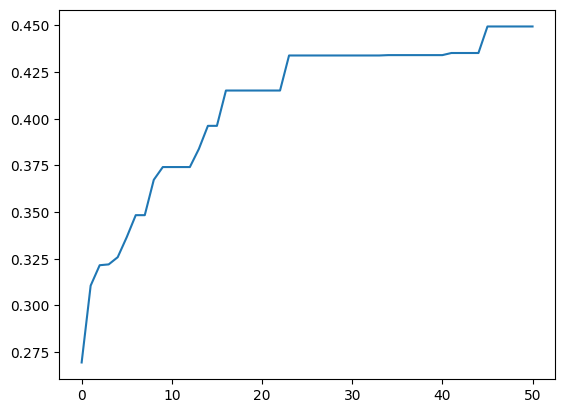

Selection: tournament - Crossover: orderpermutation - Mutation: swap - Fitness: 0.44945928435790883
Flight 7 in Sleeve 7
Flight 16 in Sleeve 3
Flight 4 in Sleeve 4
Flight 19 in Zone 0
Flight 13 in Sleeve 5
Flight 18 in Sleeve 1
Flight 28 in Zone 9
Flight 17 in Sleeve 8
Flight 6 in Sleeve 6
Flight 3 in Zone 2



In [514]:

num_individuals = 50

fitness_fn = fitness
n_generations = 50

best_fitness = 0

selection_fn_list = ['tournament'] # roulette, tournament
crossover_list = ['orderpermutation'] # onepoint, uniform, orderpermutation
mutation_list = ['swap'] # position, swap
p_mut_list = [0.5] #, 0.4, 0.45, 0.5, 0.6]
num_iteration = 10

# tournament - orderpermutation - swap - 0.3
# 

for i in range(num_iteration):
    for selection_fn in selection_fn_list:
        for crossover in crossover_list:
            for mutation in mutation_list:
                for p_mut in p_mut_list:
                    
                    # Realiza la asignacion con el algoritmo genetico
                    best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)

                    # Guardar datos de iteración
                    df = guardar_log_interacion(df, selection_fn, crossover, mutation, p_mut, 'ranking', bestfitness)

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

# imprime la mejor solucion
make_solution_report(best_ind, selection_fn, crossover, mutation)

In [465]:
resumen = df.groupby(['tipo_seleccion_padres', 'tipo_cruzamiento', 'tipo_mutacion', 'p_mut']).agg(
#resumen = df.groupby(['tipo_seleccion_padres', 'tipo_cruzamiento']).agg(
    avg_max_fitness_mean=('avg_max_fitness', 'mean'),
    avg_convergence_mean=('avg_convergence', 'mean'),
    count_rows=('avg_max_fitness', 'size')
).reset_index()
resumen = pd.DataFrame(resumen)
resumen
#resumen.sort_values(by = ['avg_max_fitness_mean'], ascending= False)
#resumen.sort_values(by = ['p_mut', 'tipo_seleccion_padres', 'tipo_cruzamiento'])

,tipo_seleccion_padres,tipo_cruzamiento,tipo_mutacion,p_mut,avg_max_fitness_mean,avg_convergence_mean,count_rows
0,tournament,orderpermutation,swap,0.4,0.444702,42.55,20


## <b>Funciones para Algoritmo Genético Multiobjetivo</b> 

In [ ]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo
    
    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [257]:
# Evalua una individuo representado por sus listas:  flights, gates
def fitness_multi(flights, gates):
  grace_time = 5/100

  #cumulative_efficiency = 0
  cumulative_passengers = 0
  cumulative_disembarkation_time = 0
  
  for flight, gate in zip(flights, gates):
    number_of_passengers = flight.number_of_passengers
    if isinstance(gate, Sleeve):  # si el gate es de tipo Manga 
      disembarkation_time_of_passengers = ( (number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) 
                                           + flight.parking_time + flight.inspection_time ) * (1 + grace_time)
    else:  # si el gate es de tipo Zona
      disembarkation_time_of_passengers = ( (number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time 
                                           + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) 
                                           + flight.inspection_time ) * (1 + grace_time)
    
    # la eficiencia de una asignacion flight-gate es la cantidad total de pasajeros desembarcados por unidad de tiempo 
    #cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers
    cumulative_passengers += number_of_passengers
    cumulative_disembarkation_time += disembarkation_time_of_passengers
  
  # validar que un gate o vuelo  no se repita en la solución
  list_identifiers_gates = []
  for i in range(len(gates)):
      list_identifiers_gates = list_identifiers_gates + [gates[i].identifier]
      
  list_identifiers_flights = []
  for i in range(len(flights)):
      list_identifiers_flights = list_identifiers_flights + [flights[i].identifier]

  if (len(list_identifiers_gates) != len(set(list_identifiers_gates))) | (len(list_identifiers_flights) != len(set(list_identifiers_flights))):
      cumulative_passengers = 1
      cumulative_disembarkation_time = 1000000

  fitness = np.zeros(2)
  fitness[0] = cumulative_passengers
  fitness[1] = 1/cumulative_disembarkation_time*1000000
  return fitness


In [266]:
# Evaluar la población con la función fitness
def evaluate_population_multi(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    #if population[i].fitness[0] == -1 or population[i].fitness[1] == -1 :
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_multi(population[i].flights, population[i].gates)

In [56]:
def build_offspring_population(population, crossover, mutation, pmut):
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)

    ## Selecciona parejas de individuos (mating_pool) para cruzamiento
    mating_pool = []
    for i in range(int(pop_size/2)):
        # escoje dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) )

    ## Crea la poblacion descendencia cruzando las parejas del mating pool
    offspring_population = []
    for i in range(len(mating_pool)):
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        elif crossover == "orderpermutation":
            offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) )
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut:
            if mutation == "position":
                offspring_population[i] = offspring_population[i].mutate_swap()
            elif mutation == "swap":
                offspring_population[i] = offspring_population[i].mutate_swap()
            else:
                raise NotImplementedError

    return offspring_population

In [43]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """

    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [42]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """
    population = deepcopy(population)
    pop_size = len(population)

    num_objectives = len(population[0].fitness)

    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness

    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)

    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)

        else:  # Si ind2_id es el mejor

            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

In [346]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto,
    """
    #population = deepcopy(population)
    pop_size = len(population)

    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if np.all(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)): # and np.any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto
        if pareto_front[i] == 1: paretofront_population.append(population[i])

    return paretofront_population

In [207]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []

    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)

        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) )

        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )

        # remueve de population los individuos que fueron agregados a next_population
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].flights) == np.asarray(population[j].flights) ):
                    del(population[j])
                    break

    return next_population

In [482]:

def graficar_frontera(pareto_front_population):
    ## Plotea los individuos de la frontera de Pareto final
    pop_size = len(pareto_front_population)
    num_objectives = len(pareto_front_population[0].fitness)

    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

    x = fitnesses[:, 0]
    y = fitnesses[:, 1]
    
    fitnesses_monoobjetivo = fitness_multi(best_ind.flights, best_ind.gates)
    plt.scatter(fitnesses_monoobjetivo[0], fitnesses_monoobjetivo[1], color='blue', marker='.', s=100, label=f"Solución MONO {i+1}")    
    
    plt.title('Análisis modelos MULTI-OBJETIVO')
    plt.xlabel('Objectivo A - Cantidad pasajeros total')
    plt.ylabel('''Objectivo B - Tiempo de descenso por pasajero 
               (1/tiempo total)''')
    plt.scatter(x,y, color='grey')
    
    plt.legend()
    plt.savefig('pareto2.png')
    plt.show()

In [269]:
population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

Generacion 0 (de 21) 
Grafico de Frontera Pareto - Generacion  0


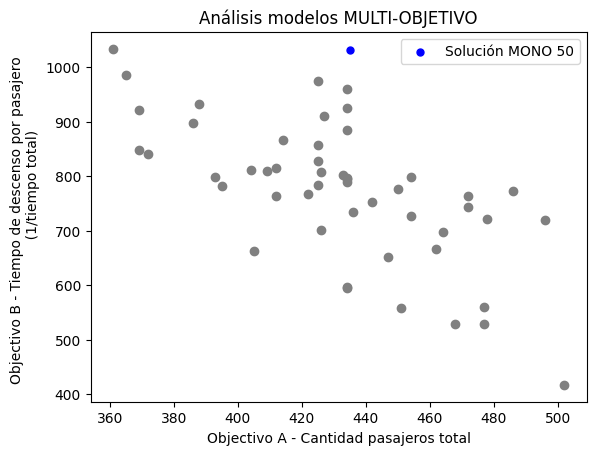

Generacion 10 (de 21) 
Generacion 20 (de 21) 
Grafico de Frontera Pareto - Generacion  20


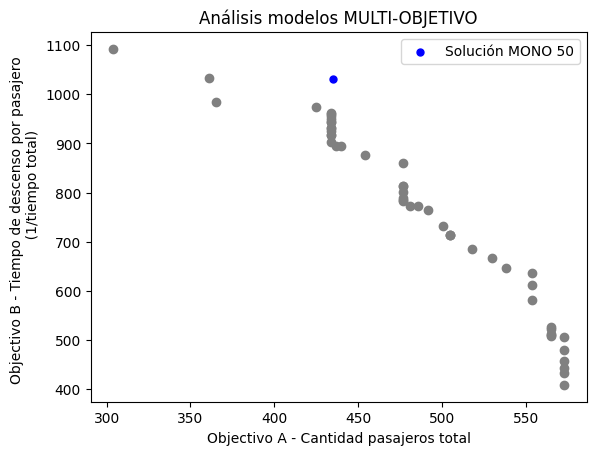

In [499]:
## CODIGO PRINCIPAL DEL  ALGORITMO GENETICO  NSGA-II

#GENERATIONS = 300
GENERATIONS = 21
MIN_POP_SIZE = 50
MAX_POP_SIZE = 50
PMUT = 0.5

P = deepcopy(population)
evaluate_population_multi(P, fitness_multi)

## Ejecuta los ciclos evolutivos
for g in range(GENERATIONS):   # Por cada generacion

    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))

    ## genera y evalua la poblacion hija
    Q = build_offspring_population(P, "orderpermutation", "swap", PMUT)
    evaluate_population_multi(Q, fitness_multi)

    ## une la poblacion padre y la poblacion hija
    P.extend(Q)

    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

    if g %20 == 0:
        print('Grafico de Frontera Pareto - Generacion ', g)
        graficar_frontera(P)
    
# Obtiene la poblacion de la frontera de pareto final
pareto_front_population = get_paretofront_population(P)

In [500]:
pop_size = 50
num_objectives = 2

fitnesses_iter3 = np.zeros([pop_size, num_objectives])
for i in range(pop_size): 
    fitnesses_iter3[i,:] = pareto_front_population[i].fitness

In [515]:
#fitnesses_mono1 = fitness_multi(best_ind.flights, best_ind.gates)
fitnesses_mono2 = fitness_multi(best_ind.flights, best_ind.gates)

<b>Grafico de Frontera de Paretto<b/>

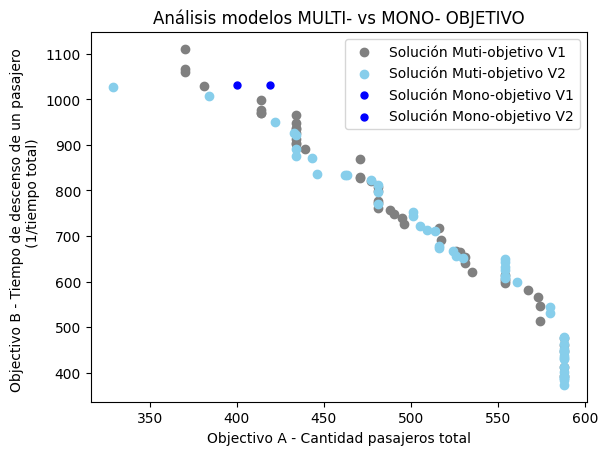

In [520]:
## Plotea los individuos de la frontera de Pareto final
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)

# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

plt.title('Análisis modelos MULTI- vs MONO- OBJETIVO')
plt.xlabel('Objectivo A - Cantidad pasajeros total')
plt.ylabel('''Objectivo B - Tiempo de descenso de un pasajero 
           (1/tiempo total)''')

x1 = fitnesses_iter1[:, 0]
y1 = fitnesses_iter1[:, 1]
plt.scatter(x1,y1, color='grey', label="Solución Muti-objetivo V1")

x2 = fitnesses_iter2[:, 0]
y2 = fitnesses_iter2[:, 1]
plt.scatter(x2,y2, color='skyblue', label="Solución Muti-objetivo V2")

# Agrega PUNTOS (X) de SOLUCION MONO OBJETIVO en la coordenada
plt.scatter(fitnesses_mono1[0], fitnesses_monoobjetivo[1], color='blue', marker='.', s=100, label=f"Solución Mono-objetivo V1")

plt.scatter(fitnesses_mono2[0], fitnesses_monoobjetivo[1], color='blue', marker='.', s=100, label=f"Solución Mono-objetivo V2")    

# Agrega PUNTOS DOMINADOS en SOLUCION MULTI OBJETIVO en la coordenada
#for i in range(len(fitnesses_dominados)):
#    plt.scatter(fitnesses_dominados[i][0], fitnesses_dominados[i][1], color='grey', marker='x', s=100, label=f"Solución MULTI dominada {i+1}")    

plt.legend()
plt.savefig('pareto2.png')
plt.show()